# Fit for first guesses on $\Gamma$ GP prior parameters

We will impose a Gaussian Process (GP) prior on the linewidth $\Gamma$ in our peakbag model. 

According to Appourchaux et al. 2014, we can describe the linewidth $\Gamma$ as:

$\ln(\Gamma) = (\alpha\ln(\nu/\nu_{\rm max}) + \ln\Gamma_\alpha) + \Large(\frac{\ln\Delta\Gamma_{\rm dip}}{1 + \Large(\frac{2\ln(\nu/\nu_{\rm dip})}{\ln(W_{\rm dip}/\nu_{\rm max}\Large)}\Large)^2}\Large)$

where we in principle have a power law tweaked by the location of a dip in the power law at $\nu_{\rm dip}$.

Instead of fitting this complex relation, we'll use a Gaussian Process and marginalise over all functions in existence, and apply this as the prior on the linewidth.

To approximate this relation we will use a squared exponential kernel:

$K_{i, j} = \alpha^2 \times \exp\left(\frac{-(\nu_i - \nu_j)^2}{2\rho^2}\right)$

where $\nu$ is the frequency and $K$ is the GP kernel, $\alpha$ is the spread and $\rho$ is the length scale. Note that I'm using the same language as the Stan User manual (some other implementations might call these $\sigma$ and $L$ respectively).

To use this effectively we will need rough first guesses for $\alpha$ and $\rho$. We will get this by reading in some mode linewidths from some random LEGACY* stars and fitting a GP to them, marginalising over $\alpha$ and $\rho$.

\*Kages doesn't report their linewidths in a way thats easy to access, unfortunately

We want:
- Some idea of the range of $\alpha$
- A rough relation for $\rho$ as a function of $\Delta\nu$ for main sequence stars

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
import pandas as pd
from astropy.io import ascii

## Read in LEGACY data

Looking at Appourchaux+14, Figure 3, we see that the shape of the $\Gamma(\nu)$ function depends on $T_\rm{eff}$. So we'll take 3 stars, one in the middle and one at each extreme of temperature on our sample.

In [2]:
#Read in stellar parameters
mal = pd.read_csv('../data/malatium.csv', index_col=0)
mal = mal[mal.source == 'L']

#Read in the mode IDS
pb = ascii.read('../data/legacy_modeids.txt').to_pandas()

In [3]:
mal.sort_values(by='Teff', inplace=True)
mal.reset_index(inplace=True, drop=True)
testteffs = [mal.Teff[0], mal.Teff[int(len(mal)/2)], mal.Teff.values[-1]]
testkics = [mal.KIC[0], mal.KIC[int(len(mal)/2)], mal.KIC.values[-1]]
# testteffs = mal.Teff[0:20]
# testkics = mal.KIC[0:20]

## Lets make a guess as to what this GP function is
We'll do this for just one of the stars

In [4]:
def kernel(x, y, p):
    ''' Returns a sqaured exponetial covariance matrix '''
    # p[0] = sigma
    # p[1] = length scale
    return p[0]**2 * np.exp(-0.5 * np.subtract.outer(x, y)**2 / p[1]**2)    

In [5]:
def predict(t_2, t_1, kernel, theta, a, c, y_1, y_v):
    B = kernel(t_1, t_2, theta).T
    A = kernel(t_1, t_1, theta).T + np.diag(y_v)
    C = kernel(t_2, t_2, theta).T
    
    y = c + np.dot(np.dot(B, np.linalg.inv(A)), (y_1 - a))
    Sigma = C - np.dot(np.dot(B, np.linalg.inv(A)),B.T)
            
    y_pred = y 
    sigma_new = np.sqrt(np.diagonal(Sigma))
    return y_pred, sigma_new

In [6]:
def plot_GP(ax, t_1, t_2, y_1, s, y_pred, sigmas, label='Observation'):
    ax.fill_between(t_2, y_pred-sigmas, y_pred+sigmas, alpha=.5, color='#8d44ad')
    ax.plot(t_2, y_pred, c='k')
    ax.errorbar(t_1, y_1, yerr=s, fmt='o', capsize=0, label=label)
    ax.legend(fontsize=15)
    ax.set_ylabel(r'Linewidth [$\mu Hz$]', fontsize=20)
    ax.set_xlabel(r'Frequency [$\mu Hz$]', fontsize=20)
    ax.legend(fontsize=20)
    return ax

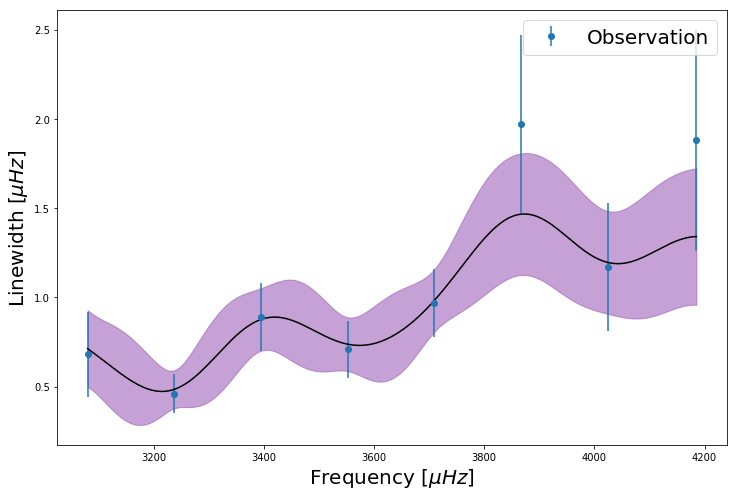

In [7]:
npts = 500
kic = testkics[0]

lw = pb[pb.KIC==str(kic)].dropna().Width.values
s = pb[pb.KIC==str(kic)].dropna().e_Width.values
f = pb[pb.KIC==str(kic)].dropna().Freq.values

theta = [.5, 100.]
a = np.ones(len(f))
c = np.ones(npts)

f2 = np.linspace(f.min(), f.max(), npts)
lw_pred, sigmas = predict(f2, f, kernel, theta, a, c, lw, s**2)

fig, ax = plt.subplots(figsize=(12,8))
ax = plot_GP(ax, f, f2, lw, s, lw_pred, sigmas)

plt.show()

This looks about reasonable! Lets use these as our first guesses.

## Lets construct the GP fitting process

In [8]:
code = '''
data {
    int N;
    real locs[N]; // The mode frequencies
    vector[N] lw; // The mode linewidths
    vector[N] mu; // The mean of the GP
    vector[N] v; // The variance on lw
    real dnu;    // The large separation
}
parameters {
    real<lower=0> rho;
    real<lower=0> alpha;
}
model {
    matrix[N, N] GP =   cov_exp_quad(locs, alpha, rho)
                     + diag_matrix(v);
                     
    alpha ~ normal(0, 10.);
    rho ~ normal(dnu, 100.);
    lw ~ multi_normal(mu, GP);
}
'''
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_543095f8bf73ec6005fb92d993614c7f NOW.
/Users/Oliver/Library/Python/3.6/lib/python/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/qv/cb2zc0gd48s1jndxjkxw8rqc0000gn/T/tmpvm805daj/stanfit4anon_model_543095f8bf73ec6005fb92d993614c7f_5115664003811287955.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


## Now lets fit each of the stars in turn

Instead of setting the mean $\mu$ of the GP to be equal to an empirical relation, we will just set it to be $1\, \mu Hz$. This is roughly the right range for MS stars.

In [1]:
alphas = np.zeros(len(testkics))
rhos = np.zeros(len(testkics))
for idx, kic in enumerate(testkics):
    lw = pb[pb.KIC==str(kic)].dropna().Width.values
    v = pb[pb.KIC==str(kic)].dropna().e_Width.values
    f = pb[pb.KIC==str(kic)].dropna().Freq.values

    dnu = mal[mal.KIC==kic].dnu.values[0]
    
    data = {'N':len(f),
             'locs':f,
           'lw':lw,
            'v':v**2,
           'mu' : np.ones(len(f)),
           'dnu' : dnu}
    
    init = {'alpha': theta[0],
            'rho' : theta[1]}

    fit = sm.sampling(data=data, iter=20000, chains=4, init=[init for x in range(4)])
    fit.plot()
    plt.show()
    print(fit)
    alphas[idx] = np.median(fit['alpha'])
    rhos[idx] = np.median(fit['rho'])

NameError: name 'np' is not defined

## Lets plot the output
We want to see:
- Whether the GP matches the data nicely
- How $\rho$ scales with $\Delta\nu$
- How $\alpha$ scales with $T_\rm{eff}$

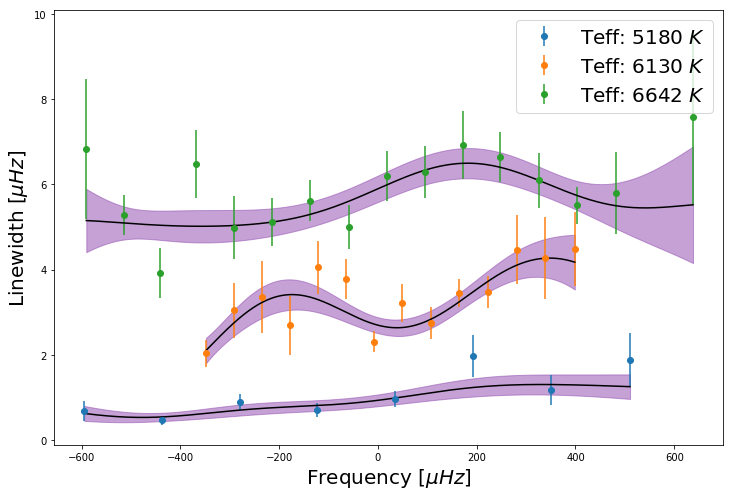

In [10]:
fig, ax = plt.subplots(figsize=(12,8))
for idx, kic in enumerate(testkics):
    lw = pb[pb.KIC==str(kic)].dropna().Width.values
    s = pb[pb.KIC==str(kic)].dropna().e_Width.values
    f = pb[pb.KIC==str(kic)].dropna().Freq.values

    numax = mal[mal.KIC==kic].numax.values[0]
    
    a = np.ones(len(f))
    c = np.ones(npts)
    
    theta = [alphas[idx],rhos[idx]]
        
    f2 = np.linspace(f.min(), f.max(), npts)
    lw_pred, sigmas = predict(f2, f, kernel, theta, a, c, lw, s**2)

    ax = plot_GP(ax, f-numax, f2-numax, lw, s, lw_pred, sigmas,
                label=r'Teff: {} $K$'.format(testteffs[idx]))

plt.show()

Text(0, 0.5, 'Alpha')

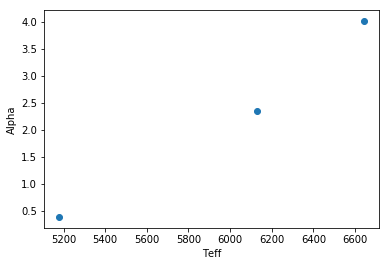

In [11]:
dnus = [mal[mal.KIC==kic].dnu.values[0] for kic in testkics]
plt.scatter(testteffs, alphas)
plt.xlabel('Teff')
plt.ylabel('Alpha')

**Conclusion**: Alpha ranges from 0.5 to 4. in the LEGACY range of stars. A prior of:

$\alpha \sim \mathcal{N}(2.5, 2.)$

will be appropriate.

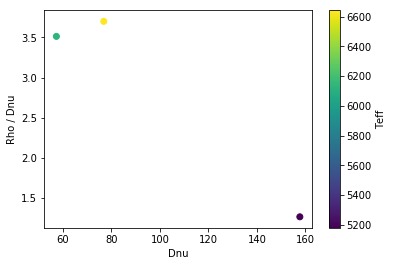

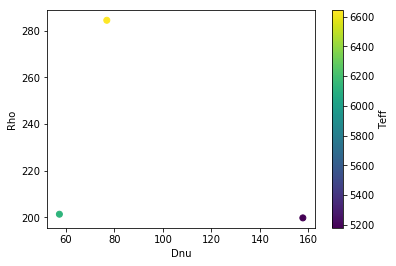

In [12]:
plt.scatter(dnus, rhos/dnus, c=testteffs)
plt.colorbar(label='Teff')
plt.xlabel('Dnu')
plt.ylabel('Rho / Dnu')
plt.show()

plt.scatter(dnus, rhos, c=testteffs)
plt.colorbar(label='Teff')
plt.xlabel('Dnu')
plt.ylabel('Rho')
plt.show()

**Conclusion:** When looking at a larger sample of stars ($N=20$) it looks like on average $\rho$ falls at 250, with no trend with $\Delta\nu$. There are some outliers of course, but in general we can probably fix $\rho$ to $250\, \mu Hz$ and be happy.